# Исследование зависимости объемов продаж от рекламных акций и прогноз продаж

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import os
import itertools

### 1. Загрузка и первичный анализ данных

In [3]:
sales_train_df = pd.read_csv('./DS_task/sales_train.csv', parse_dates=['date'])
advert_train_df = pd.read_csv('./DS_task/advert_train.csv', parse_dates=['date'])
advert_test_df = pd.read_csv('./DS_task/advert_test.csv', parse_dates=['date'])
deploy_example_df = pd.read_csv('./DS_task/deploy_example.csv', parse_dates=['date'])

In [4]:
#sales_train_df.info()

In [5]:
#advert_train_df.info()

In [6]:
#advert_test_df.info()

In [7]:
#deploy_example_df.info()

In [8]:
Nstores = 8

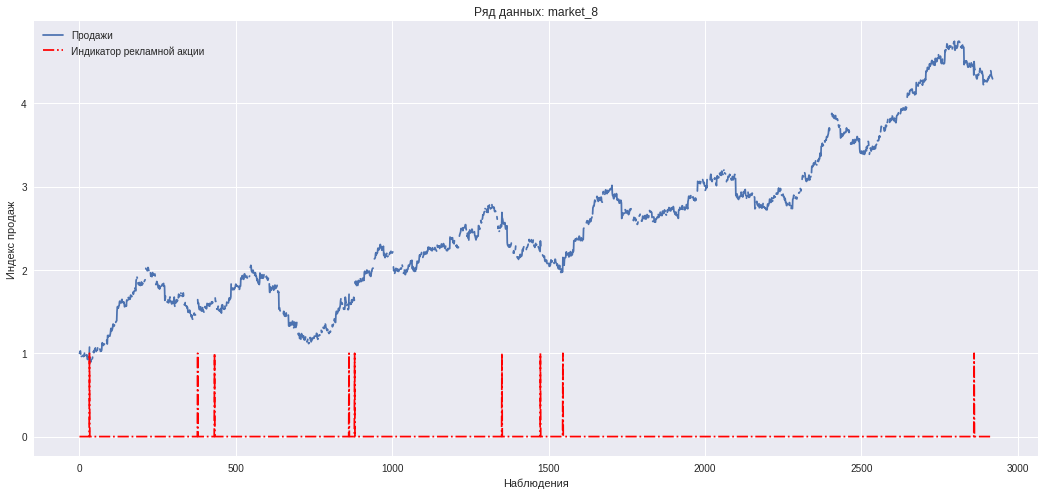

In [9]:
mkt_tag = 8

fig, ax = plt.subplots(1, 1, figsize=(18,8))

mkt_str = 'market_'+str(mkt_tag)
ax.plot(sales_train_df[mkt_str], label=u'Продажи')
ax.plot(advert_train_df[mkt_str], label=u'Индикатор рекламной акции', color='r', linestyle='-.')
ax.set_title(u'Ряд данных: '+mkt_str)
ax.set_xlabel(u'Наблюдения')
ax.set_ylabel(u'Индекс продаж')
plt.legend()
plt.show()
#fig.savefig(mkt_str+'.png')

Из графиков видим, что системного влияния у рекламных компаний нет. Если есть, то это какое-то локальное действие. Можно отметить достаточно много пропусков в данных.

In [10]:
# посмотрим, что происходит в окрестности момента рекламной компании
adv_dates_list = advert_train_df[advert_train_df[mkt_str]==1].index

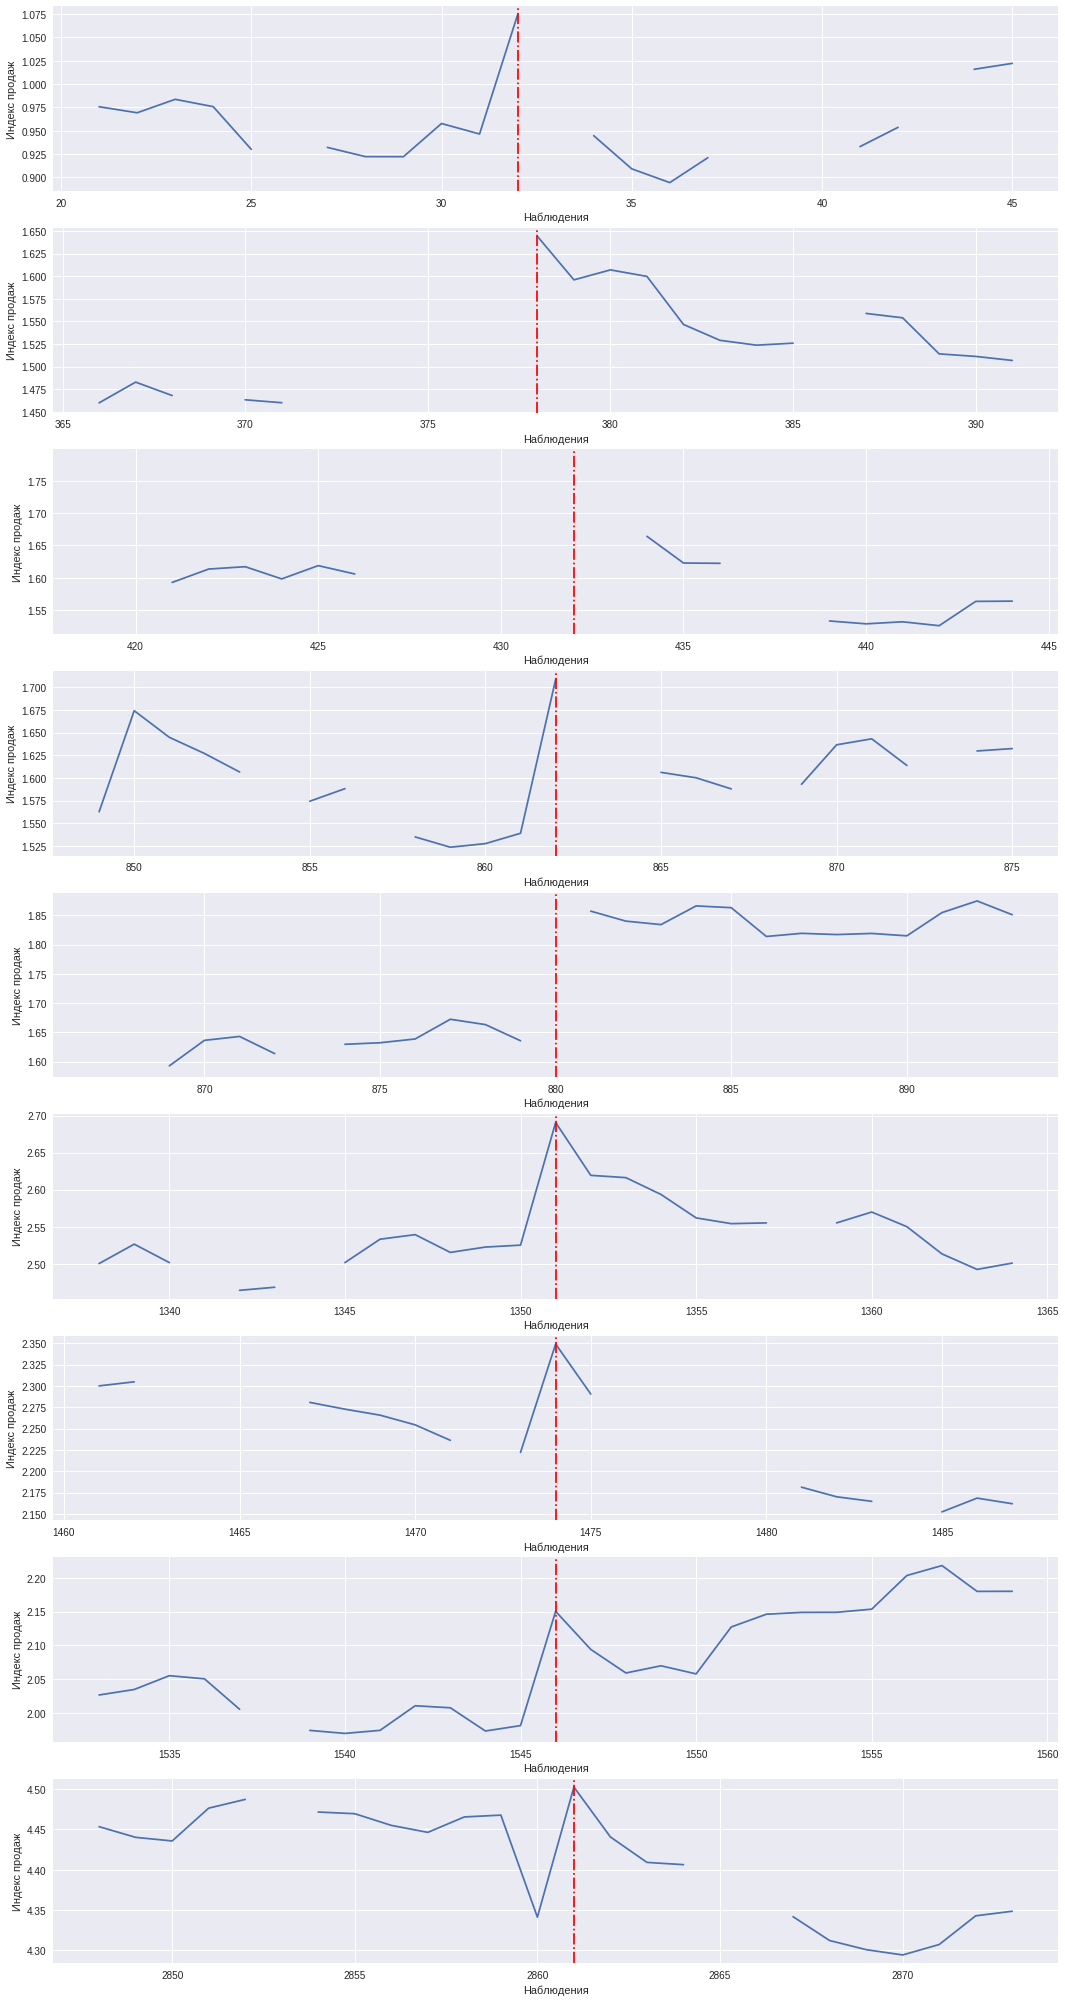

In [11]:
fig, ax = plt.subplots(len(adv_dates_list), 1, figsize=(18,4*len(adv_dates_list)))

days_range = 13

for i in range(len(adv_dates_list)):
    ax[i].plot(sales_train_df[(sales_train_df.index>=adv_dates_list[i]-days_range)&\
                           (sales_train_df.index<=adv_dates_list[i]+days_range)][mkt_str])
    ax[i].axvline(x=adv_dates_list[i], color='r', linestyle='-.')
    ax[i].set_xlabel(u'Наблюдения')
    ax[i].set_ylabel(u'Индекс продаж')

plt.show()
#fig.savefig(mkt_str+'_adv.png')

** Предлагается следующий порядок действий для анализа продаж по каждому из магазинов: **
<ol>
<li>**Анализ влияния рекламных акций на объемы продаж.**
    <ol>
    <li>Удаляем из ряда данных по продажам точки, соответствующие датам проведения рекламных акций (ставим как n/a).</li>
    <li>Заполняем пропуски в данных с интерполяцией значений между соседями. </li>
    <li>Сравниваем значения продаж в даты проведения рекламных акций - фактические и полученные в результате интерполяции на предыдущем шаге.</li>
    <li>Делаем вывод о влиянии рекламной акции на объем продаж (либо по каждому магазину, либо в совокупности), оценивая соответствующий коэффициент корректировки объема продаж.</li>
    </ol>
</li>

<li>**Построение прогноза продаж.**
    <ol>
    <li>Строим прогноз продаж по каждому из магазинов на основе рядов данных с интерполяцией и без рекламных акций с использованием модели SARIMA.</li> 
    <li>Корректируем полученный прогноз в датах проведения рекламных акций с учетом полученных коэффициентов.</li>
    </ol>
</li>
</ol>

### 2. Оценка влияния рекламных акций

In [12]:
#шаг 1.A
data_df = sales_train_df.copy()

for c_ in data_df.columns[1:]:
    data_df.loc[advert_train_df[advert_train_df[c_]==1].index, c_] = np.nan

#шаг 1.B
data_df.interpolate(axis=0, inplace=True)

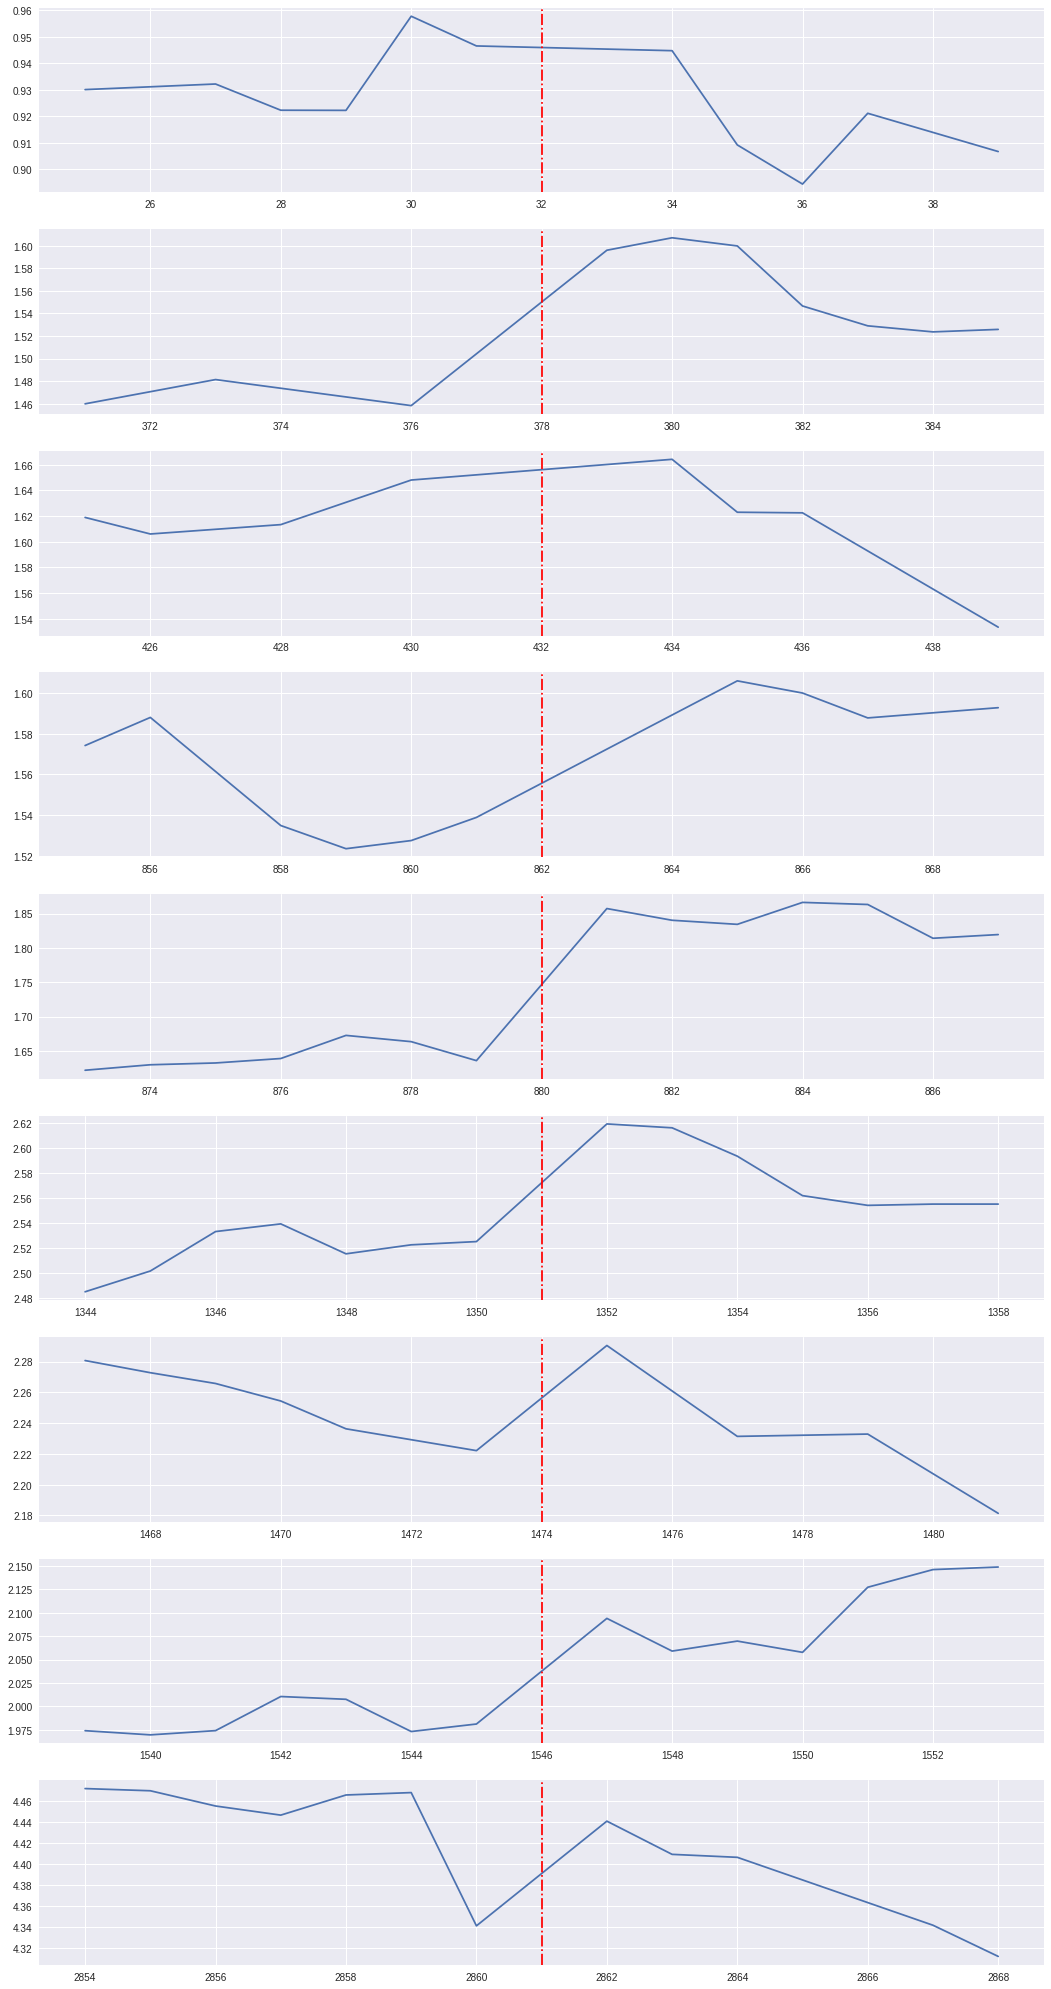

In [13]:
fig, ax = plt.subplots(len(adv_dates_list), 1, figsize=(18,4*len(adv_dates_list)))

days_range = 7
mkt_str = 'market_'+str(mkt_tag)
#fig.suptitle(mkt_str, fontsize=16)

for i in range(len(adv_dates_list)):
    ax[i].plot(data_df[(data_df.index>=adv_dates_list[i]-days_range)&\
                       (data_df.index<=adv_dates_list[i]+days_range)][mkt_str])
    ax[i].axvline(x=adv_dates_list[i], color='r', linestyle='-.')
plt.show()

In [14]:
#шаг 1.C
#проанализируем пары значений объемов продаж без рекламной акции и с рекламной акцией
sales_noadv = []
sales_adv = []
mkt = []
for c_ in data_df.columns[1:]:
    sales_noadv.append(list(data_df.loc[advert_train_df[advert_train_df[c_]==1].index, c_]))
    sales_adv.append(list(sales_train_df.loc[advert_train_df[advert_train_df[c_]==1].index, c_]))
    mkt.append([c_]*len(list(data_df.loc[advert_train_df[advert_train_df[c_]==1].index, c_])))
sales_noadv = list(itertools.chain(*sales_noadv))
sales_adv = list(itertools.chain(*sales_adv))
sales_mkt = list(itertools.chain(*mkt))

In [15]:
sadv_df = pd.DataFrame(columns = ['market_id', 'noadv', 'adv'], 
                       data=[(mkt, noadv,adv) for (mkt,noadv,adv) in zip (sales_mkt,sales_noadv,sales_adv)])

In [16]:
sadv_df.dropna(axis=0,inplace=True)

In [17]:
sadv_df['diff'] = sadv_df['adv']-sadv_df['noadv']
sadv_df['ratio'] = sadv_df['adv']*1.0/sadv_df['noadv']

In [18]:
sadv_df[sadv_df['market_id']=='market_1'].describe()

,noadv,adv,diff,ratio
count,6.000000,6.000000,6.000000,6.000000
mean,1.756016,1.873297,0.117280,1.069213
std,0.324428,0.324499,0.015435,0.018145
min,1.199214,1.320195,0.097031,1.048564
25%,1.651009,1.762671,0.107471,1.059352
50%,1.808610,1.928799,0.116394,1.065767
75%,1.983616,2.084341,0.126673,1.074254
max,2.079237,2.218504,0.139266,1.100884


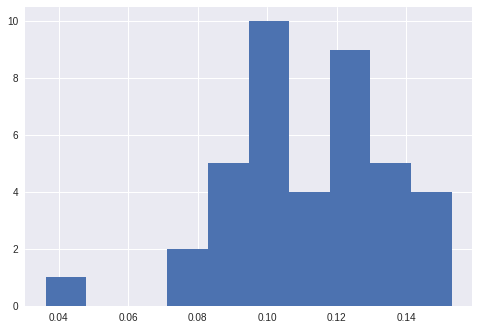

In [19]:
sadv_df['diff'].hist(bins=10)
plt.show();

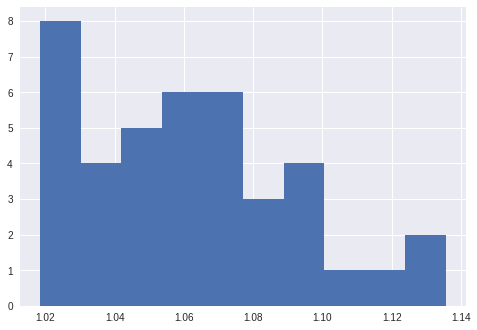

In [20]:
sadv_df['ratio'].hist(bins=10)
plt.show();

**Вывод:** У абсолютной разницы разброс меньше, поэтому для корректировки объема продаж в день проведения рекламной акции будем применять аддитивную (а не мультипликативную) корректировку.

### 3. Прогноз объемов продаж

In [21]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

/home/as/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [22]:
# значение market_id ниже будем менять вручную для проведения анализа данных и построения 
# прогноза по каждому из магазинов
market_id = 8

work_data = pd.DataFrame(data=data_df[['date','market_'+str(market_id)]])
work_data.set_index('date', inplace=True)
work_data.rename(columns={'market_'+str(market_id): 'sales'}, inplace=True)

В ходе анализа выяснилось, что у ряда есть сезонность в 364 дня, при этом это слишком большое значение сезонного лага для модели SARIMA из statsmodels. Поэтому для дальнейшей работы огрубляем данные до недель.

In [23]:
work_data = work_data.resample('W').mean()

**3.1. Проверка на стационарность ряда, стабилизация дисперсии, дифференцирование ряда**

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.961376


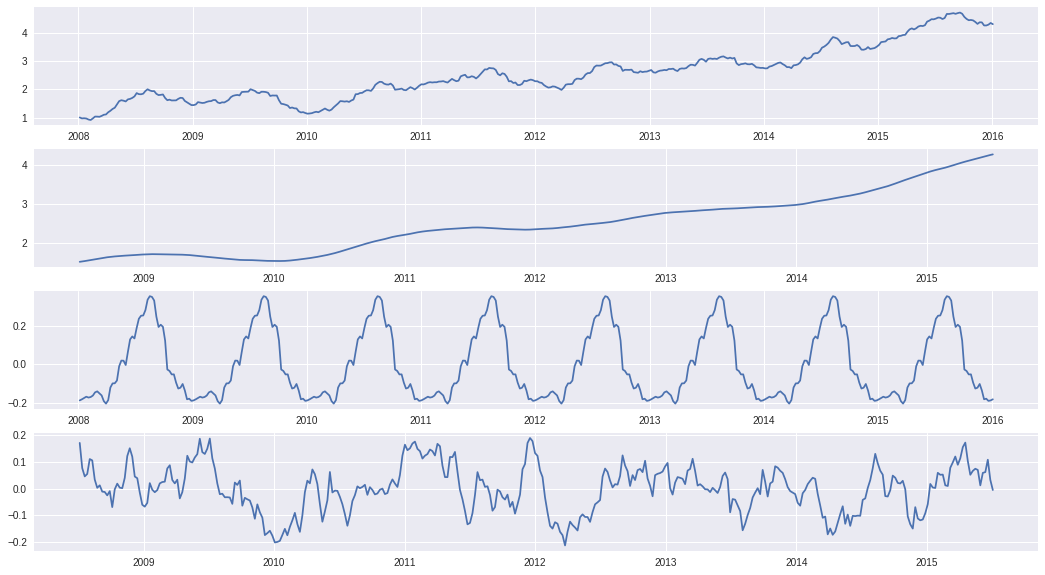

In [24]:
fig, ax = plt.subplots(4,1,figsize=(18,10))
_decomposed = sm.tsa.seasonal_decompose(work_data.sales)
ax[0].plot(_decomposed.observed)
ax[1].plot(_decomposed.trend)
ax[2].plot(_decomposed.seasonal[:])
ax[3].plot(_decomposed.resid)

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(work_data.sales)[1])
plt.show();

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.244696
Критерий Дики-Фуллера: p=0.880918


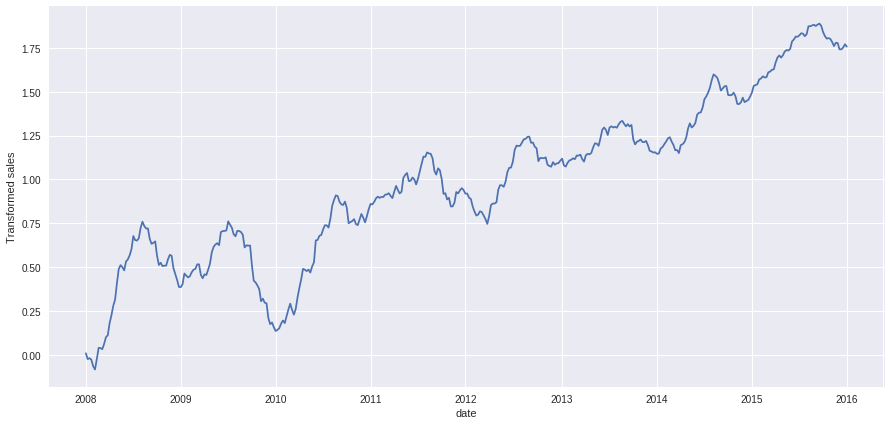

In [25]:
work_data['sales_box'], lmbda = stats.boxcox(work_data.sales)
plt.figure(figsize=(15,7))
work_data.sales_box.plot()
plt.ylabel(u'Transformed sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(work_data.sales_box)[1])
plt.show()

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.032906


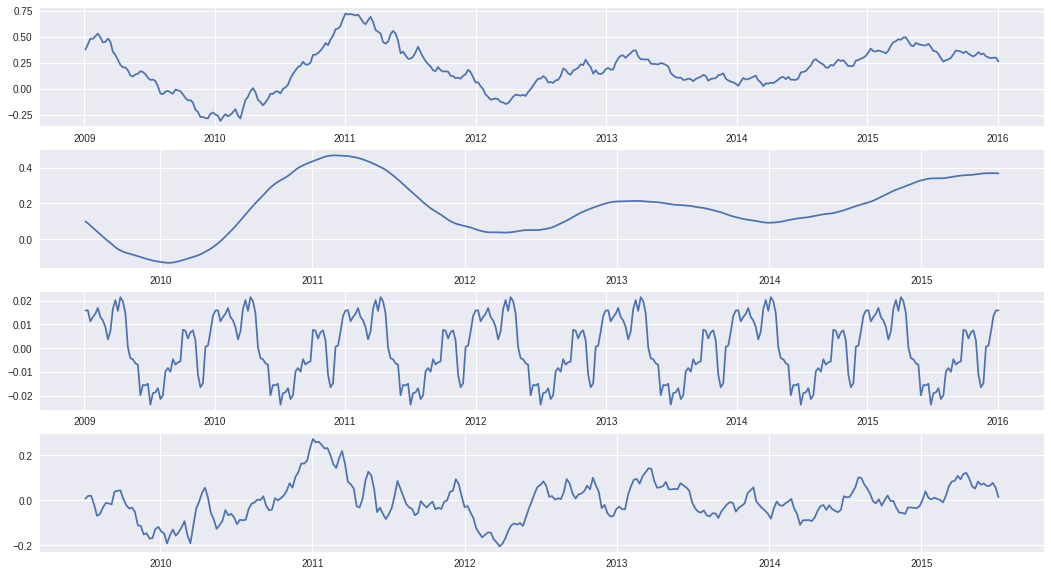

In [26]:
seasonal_shift = 52 #364

work_data['sales_box_diff'] = work_data.sales_box - work_data.sales_box.shift(seasonal_shift)
_decomposed = sm.tsa.seasonal_decompose(work_data.sales_box_diff[seasonal_shift:])

fig, ax = plt.subplots(4,1,figsize=(18,10))
ax[0].plot(_decomposed.observed)
ax[1].plot(_decomposed.trend)
ax[2].plot(_decomposed.seasonal[:])
ax[3].plot(_decomposed.resid)

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(work_data.sales_box_diff[seasonal_shift:])[1])
plt.show()

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000869


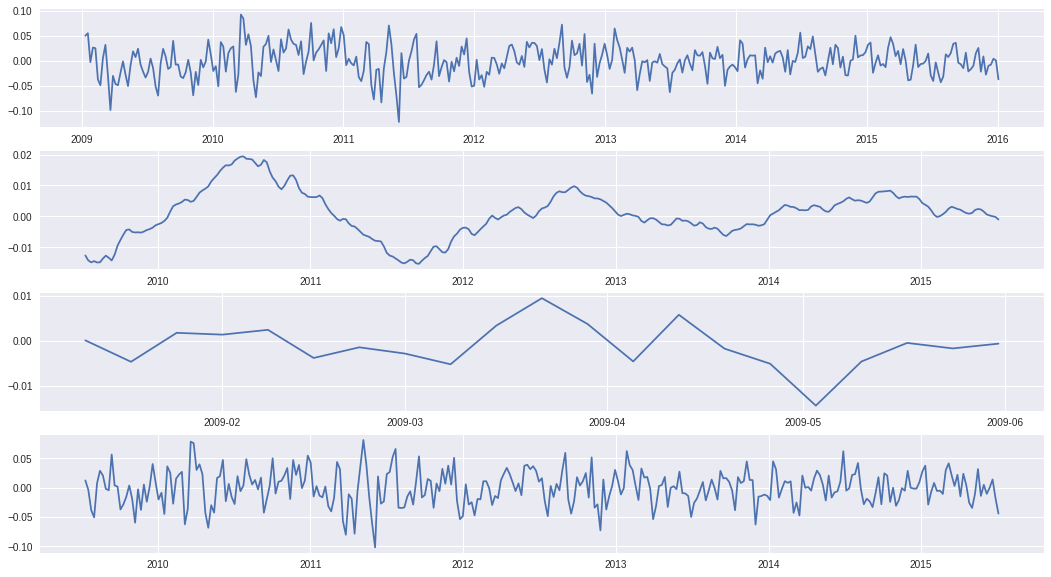

In [27]:
shift2 = 1

work_data['sales_box_diff2'] = work_data.sales_box_diff - work_data.sales_box_diff.shift(shift2)
_decomposed = sm.tsa.seasonal_decompose(work_data.sales_box_diff2[seasonal_shift+shift2:])

fig, ax = plt.subplots(4,1,figsize=(18,10))
ax[0].plot(_decomposed.observed)
ax[1].plot(_decomposed.trend)
ax[2].plot(_decomposed.seasonal[:21])
ax[3].plot(_decomposed.resid)

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(work_data.sales_box_diff2[seasonal_shift+shift2:])[1])
plt.show()

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — очевидного тренда больше нет. 

**3.2. Подбор параметров модели**

Визуальный анализ ACF и PACF полученного ряда:

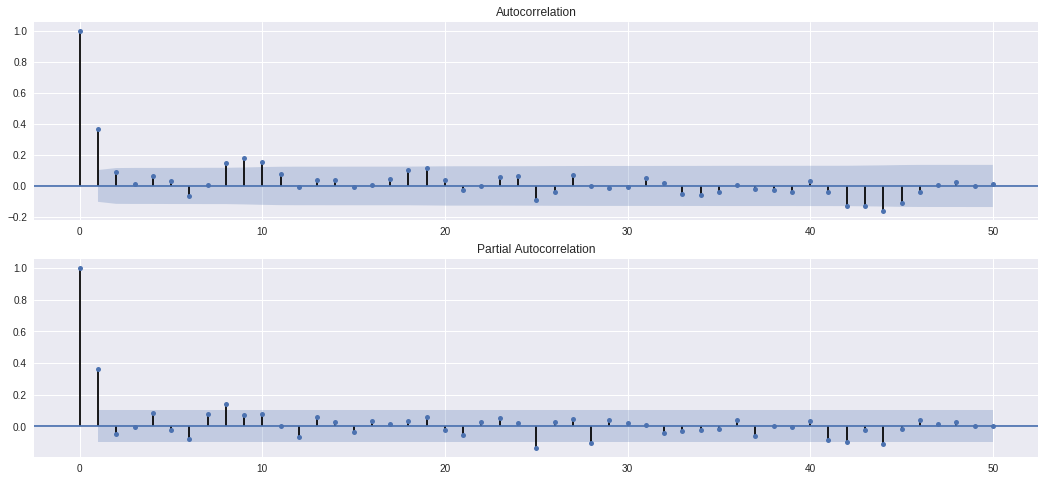

In [28]:
plt.figure(figsize=(18,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(work_data.sales_box_diff2[seasonal_shift+shift2:].values.squeeze(), lags=50, ax=ax)
#plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(work_data.sales_box_diff2[seasonal_shift+shift2:].values.squeeze(), lags=50, ax=ax)
plt.show()

In [29]:
# начальные значения параметров:

# Q - номер последнего сезонного лага, при котором автокорреляция значима
# q - номер последнего несезонного лага, при котором автокорреляция значима
# D - число раз сезонного дифференцирования
# d - число раз обычного дифференцирования
# P - номер последнего сезонного лага, при котором частичная автокорреляция значима
# p - номер последнего несезонного лага, при котором частичная автокорреляция значима

#rules of thumb:
# d+D <= 2
# p+d+q+P+D+Q <= 6

ps = range(1, 3)
d=1
qs = range(1, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [30]:
# формируем список параметров для поиска их оптимального сочетания для построения модели
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))

16


In [31]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(work_data.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], seasonal_shift),
                                        ).fit(disp=-1)
        
    #выводим параметры, на которых модель не обучается, и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    print('aic:', aic)
    #сохраняем лучшую модель (по критерию Акаике), aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(1, 1, 0, 0)
('aic:', -1547.6674081055019)
(1, 1, 0, 1)
('aic:', -1626.9485886308266)
(1, 1, 1, 0)
('aic:', -1621.6075250157855)
(1, 1, 1, 1)
('aic:', -1626.3106402332962)
(1, 2, 0, 0)
('aic:', -1547.2221485717876)
(1, 2, 0, 1)
('aic:', -1629.543545973283)
(1, 2, 1, 0)
('aic:', -1622.5697442966816)
(1, 2, 1, 1)
('aic:', -1628.9079882048848)
(2, 1, 0, 0)
('aic:', -1545.7168147738557)
(2, 1, 0, 1)
('aic:', -1625.2707346381196)
(2, 1, 1, 0)
('aic:', -1620.1690659920291)
(2, 1, 1, 1)
('aic:', -1624.6810668922124)
(2, 2, 0, 0)
('aic:', -1545.851431967471)
(2, 2, 0, 1)
('aic:', -1632.0143855530425)
(2, 2, 1, 0)
('aic:', -1623.524741082988)
(2, 2, 1, 1)
('aic:', -1629.9671234319208)
CPU times: user 26min 19s, sys: 11min 43s, total: 38min 2s
Wall time: 9min 58s


In [32]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
13  (2, 2, 0, 1) -1632.014386
15  (2, 2, 1, 1) -1629.967123
5   (1, 2, 0, 1) -1629.543546
7   (1, 2, 1, 1) -1628.907988
1   (1, 1, 0, 1) -1626.948589


Лучшая модель и анализ ее остатков:

In [33]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  418
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 52)   Log Likelihood                 822.007
Date:                            Thu, 29 Nov 2018   AIC                          -1632.014
Time:                                    23:32:12   BIC                          -1607.801
Sample:                                01-06-2008   HQIC                         -1622.443
                                     - 01-03-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0669      0.255     -0.262      0.793      -0.567       0.433
ar.L2         -0.4109      0.119   

Критерий Стьюдента: p=0.789121
Критерий Дики-Фуллера: p=0.000000


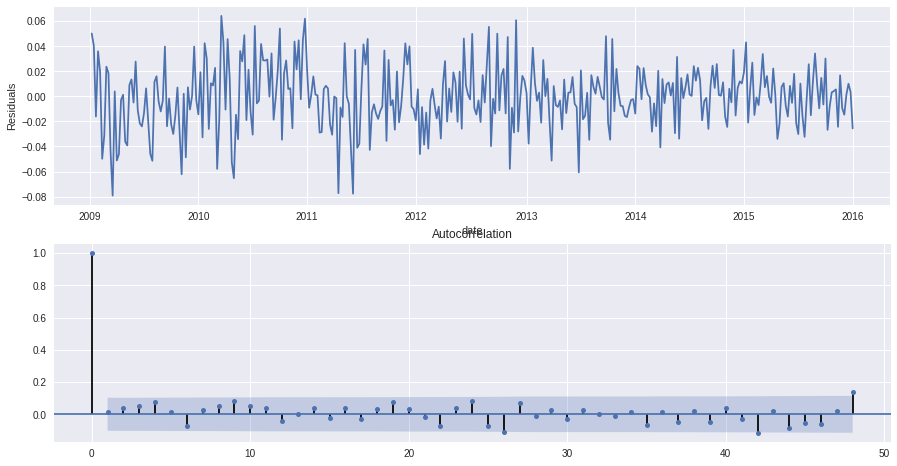

In [34]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[seasonal_shift+shift2:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[seasonal_shift+shift2:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[seasonal_shift+shift2:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[seasonal_shift+shift2:])[1])
plt.show()

Выводы по анализу остатков:

1. Несмещенность (матожидание равно 0) - подтверждается критерием Стьдента (p-value>0.05)

2. Стационарность - подтверждается критерием Дики-Фуллера (p-value<0.05)

3. Отсутствие автокорреляции - подтверждается критерием Льюнга-Бокса (p-value>0.05) и коррелограммой


Посмотрим, насколько хорошо модель описывает данные:

<Figure size 576x396 with 0 Axes>

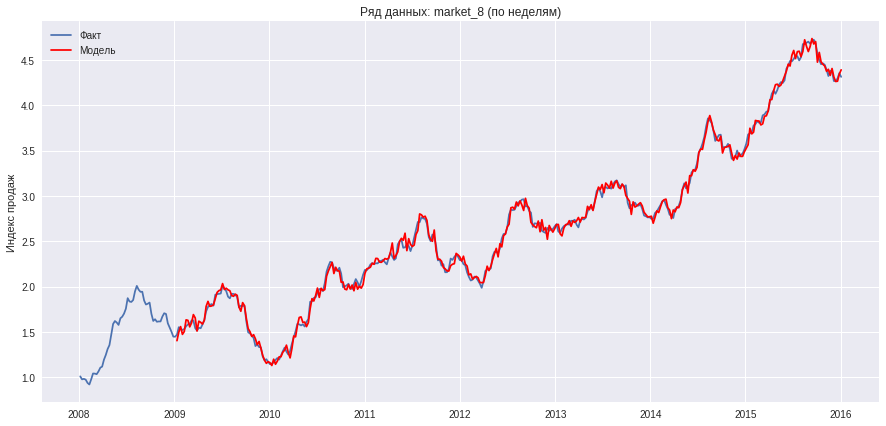

In [58]:
work_data['model'] = invboxcox(best_model.fittedvalues, lmbda)
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(work_data.sales, label=u'Факт')
ax.plot(work_data.model[seasonal_shift+shift2:], label=u'Модель', color='r')
ax.set_title(u'Ряд данных: market_'+str(market_id)+u' (по неделям)')
#ax.set_xlabel(u'Наблюдения')
ax.set_ylabel(u'Индекс продаж')
plt.legend()
plt.show()
#fig.savefig('market_'+str(market_id)+'_check.png')

**3.3. Построение прогноза**

In [39]:
import datetime
import dateutil.relativedelta

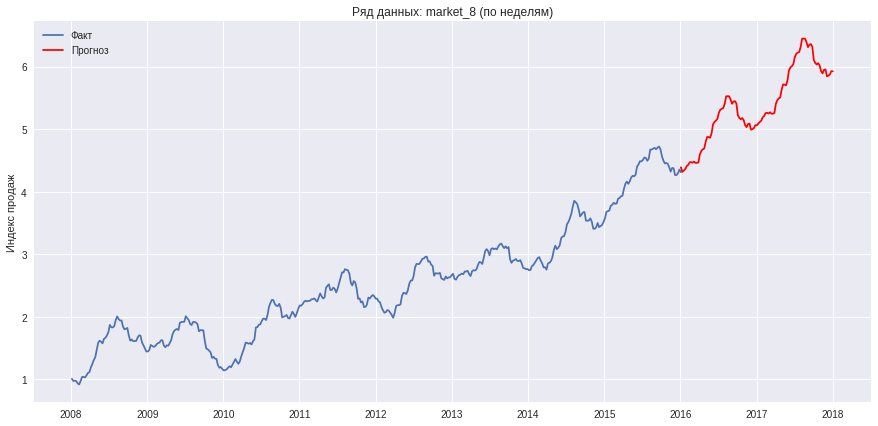

In [59]:
work_data2 = work_data[['sales']]
date_list = [datetime.datetime.strptime("2016-01-10", "%Y-%m-%d") + dateutil.relativedelta.relativedelta(weeks=x) for x in range(0,729/7+1)]

future = pd.DataFrame(index=date_list, columns= work_data2.columns)
work_data2 = pd.concat([work_data2, future])
work_data2['forecast'] = invboxcox(best_model.predict(start=417, end=417+729/7), lmbda)

fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(work_data2.sales, label=u'Факт')
ax.plot(work_data2.forecast, label=u'Прогноз', color='r')
ax.set_ylabel(u'Индекс продаж')
ax.set_title(u'Ряд данных: market_'+str(market_id)+u' (по неделям)')
plt.legend()
plt.show()
#fig.savefig('market_'+str(market_id)+'_forecast.png')

In [51]:
# далее стыкуем факт и прогноз и делаем интерполяцию, возвращая разрешение ряда по дням
for d_ in ['2015-12-27','2016-01-03']:
    work_data2.loc[d_, 'forecast'] = work_data2.loc[d_, 'sales']

In [52]:
deploy_data = work_data2[-len(future)-2:].resample('D').interpolate()[5:-9]
a = deploy_data.forecast.sum()

In [53]:
#шаг 2.B
#используем аддитивную корректировку на рекламную акцию
deploy_data.loc[advert_test_df[advert_test_df['market_'+str(market_id)]==1]['date'],'forecast'] += sadv_df['diff'].mean()
print(deploy_data.forecast.sum()-a)

0.2236116278445479


In [54]:
deploy_example_df.loc[:,'market_'+str(market_id)] = list(deploy_data['forecast'])

In [55]:
sadv_df['diff'].mean()

0.11180581392224567

In [57]:
#deploy_example_df

**Далее проделываем аналогичный анализ по каждому из 8 магазинов и сохраняем результат в нужном формате**

In [463]:
#deploy_example_df.to_csv('./DS_task/deploy_test_29.11.2018.csv', index=False)